In [1]:
 import pandas as pd
 import matplotlib.pyplot as plt
 import seaborn as sns
 import numpy as np
 from sklearn.model_selection import train_test_split, cross_val_score
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.preprocessing import StandardScaler
 from sklearn.metrics import accuracy_score, classification_report
 from sklearn.cluster import KMeans
 from sklearn.feature_selection import SelectKBest, f_classif
 from scipy import stats
 from sklearn.tree import DecisionTreeClassifier
 from sklearn.linear_model import LogisticRegression
 from sklearn.metrics import (accuracy_score, precision_score,
 recall_score,
 f1_score, confusion_matrix,
 classification_report,
 roc_curve, roc_auc_score)
 from sklearn.pipeline import Pipeline

# Set styling for all plots


In [3]:
 plt.style.use('seaborn-v0_8')
 sns.set_palette("husl")
 plt.rcParams['figure.figsize'] = [12, 8]
 df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")
 df.head()


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [4]:
 print("A. Basic statistical summaries")
 print("\nDataset shape:", df.shape)
 print("\nColumn types:")
 print(df.dtypes)
 print("\nSummary statistics for numerical columns:")
 print(df.describe())
 print("\nClass distribution:")
 print(df['label'].value_counts(normalize=True))

A. Basic statistical summaries

Dataset shape: (235795, 56)

Column types:
FILENAME                       object
URL                            object
URLLength                       int64
Domain                         object
DomainLength                    int64
IsDomainIP                      int64
TLD                            object
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRa

## 1. Class Distribution Analysis

Analyze and visualize the distribution of legitimate vs
 phishing URLs

In [6]:

 def analyze_class_distribution(df):

    plt.figure(figsize=(10, 6))
    class_dist = df['label'].value_counts()
    plt.pie(class_dist,
    labels=['Legitimate' if i == 1 else 'Phishing' for i in
    class_dist.index],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'])
    plt.title('Distribution of URLs in Dataset')
    plt.axis('equal')
    plt.show()
    print("\nClass Distribution Summary:")
    print(f"Total URLs: {len(df):,}")
    print(f"Legitimate URLs: {class_dist[1]:,} ({class_dist[1]/len(df)*100:.1f}%)")
    print(f"Phishing URLs: {class_dist[0]:,} ({class_dist[0]/len(df)*100:.1f}%)")
    # Execute the analysis
    analyze_class_distribution(df)

## 2. Numerical Features Analysis
Analyze key numerical features with box plots and statistical
 tests

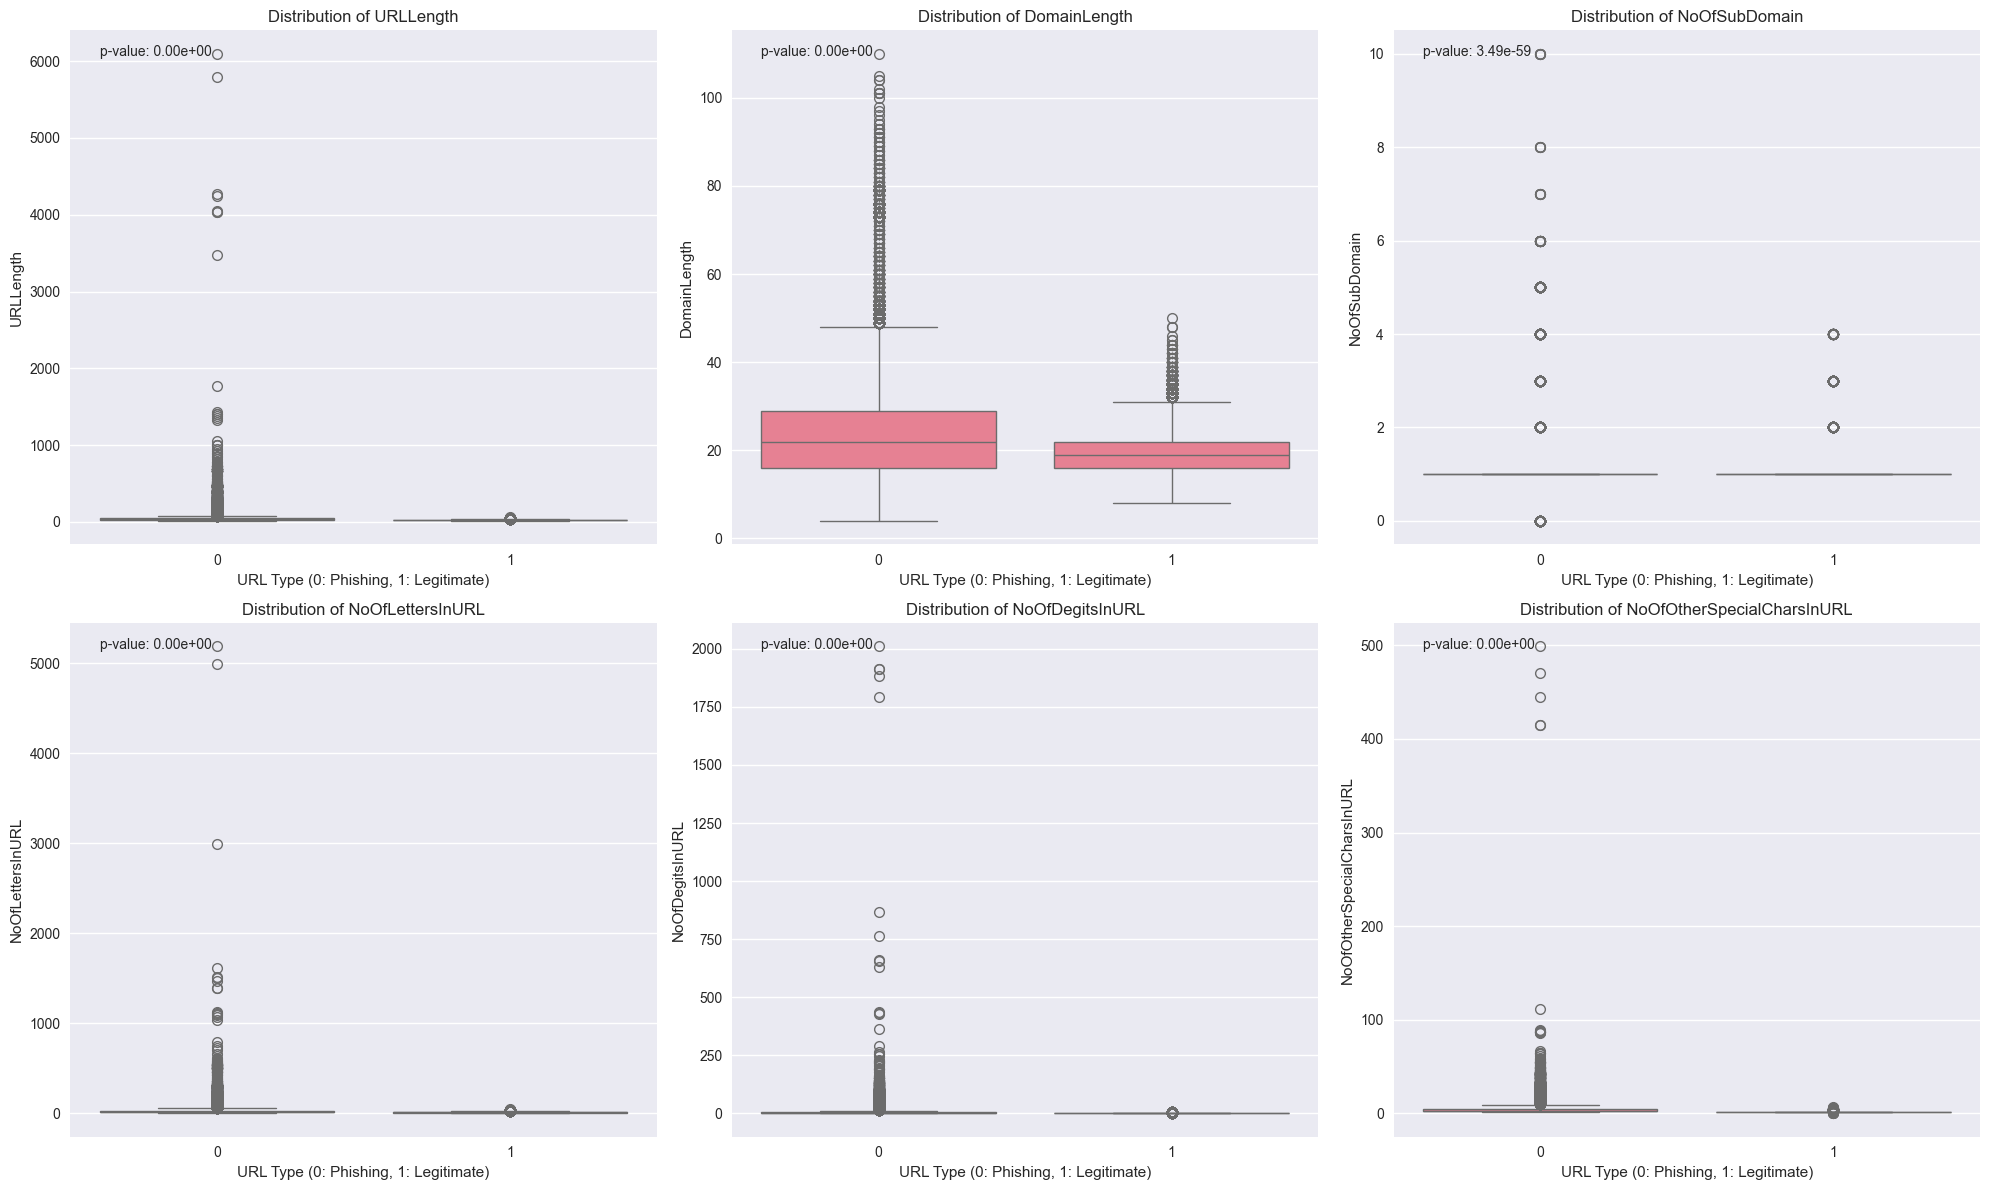

In [16]:
 def analyze_numerical_features(df):
     key_features = ['URLLength', 'DomainLength', 'NoOfSubDomain', 
                      'NoOfLettersInURL', 'NoOfDegitsInURL', 
                      'NoOfOtherSpecialCharsInURL']
     # Create box plots for each feature
     fig, axes = plt.subplots(2, 3, figsize=(20, 12))
     axes = axes.ravel()
     for idx, feature in enumerate(key_features):
          sns.boxplot(x='label', y=feature, data=df, ax=axes[idx])
          axes[idx].set_xlabel('URL Type (0: Phishing, 1: Legitimate)')
          axes[idx].set_title(f'Distribution of {feature}')
          # Perform Mann-Whitney U test
          stat, p_value = stats.mannwhitneyu(
               df[df['label'] == 0][feature],
               df[df['label'] == 1][feature]
          )
          axes[idx].text(0.05, 0.95, f'p-value: {p_value:.2e}', transform=axes[idx].transAxes)
     plt.tight_layout()
     plt.show()
     
# Execute the analysis
analyze_numerical_features(df)


## 3. Correlation Analysis
Create and visualize correlation matrix for important
 features

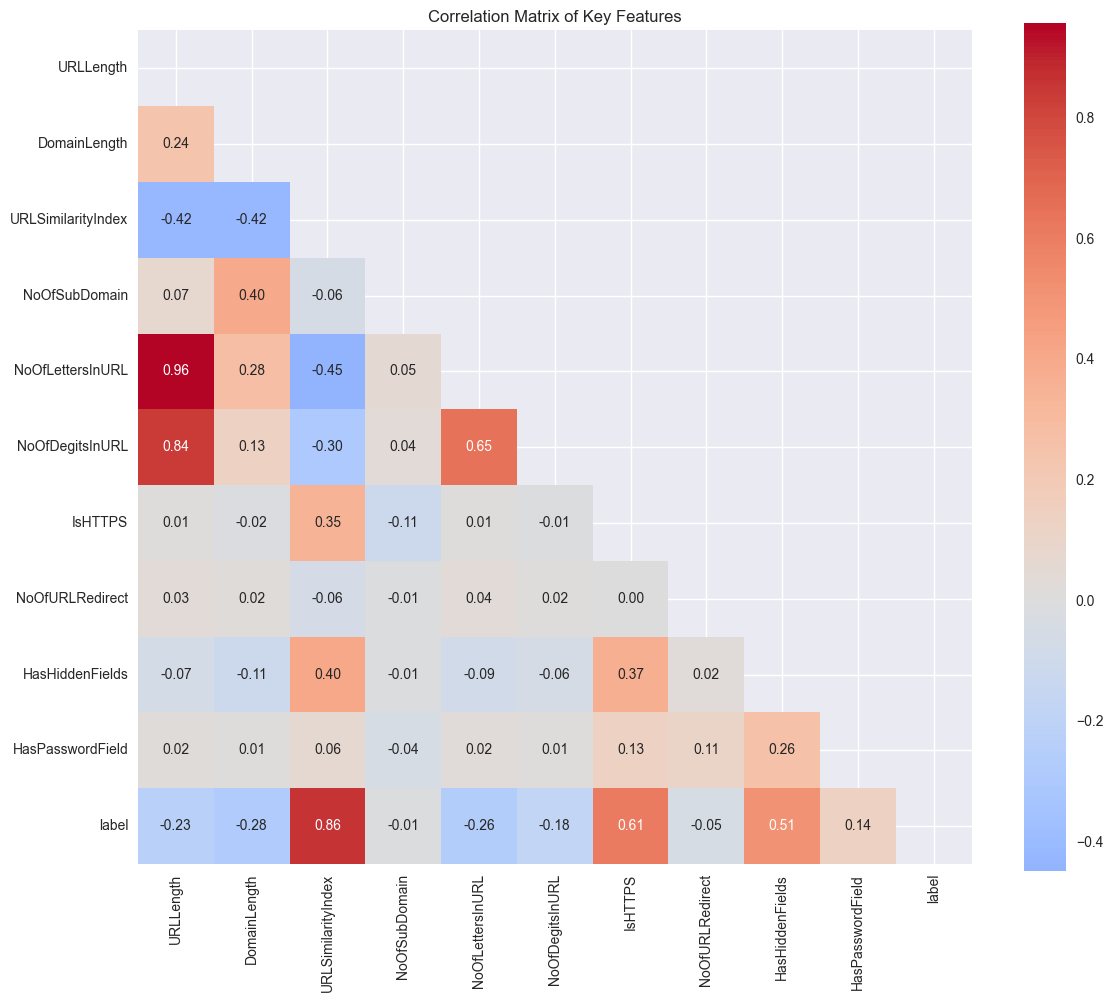


Strong correlations (|r| > 0.5):
URLLength NoOfLettersInURL: 0.956
URLLength NoOfDegitsInURL: 0.836
URLSimilarityIndex label: 0.860
NoOfLettersInURL NoOfDegitsInURL: 0.648
IsHTTPS label: 0.609
HasHiddenFields label: 0.508


In [17]:

 def create_correlation_matrix(df):
 
    important_features = ['URLLength', 'DomainLength', 'URLSimilarityIndex', 
                          'NoOfSubDomain', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'IsHTTPS',
                          'NoOfURLRedirect', 'HasHiddenFields', 'HasPasswordField', 'label' ]
    corr_matrix = df[important_features].corr()
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
    annot=True, fmt='.2f', square=True)
    plt.title('Correlation Matrix of Key Features')
    plt.tight_layout()
    plt.show()
    # Print strong correlations
    print("\nStrong correlations (|r| > 0.5):")
    for i in range(len(important_features)):
        for j in range(i+1, len(important_features)):
            if abs(corr_matrix.iloc[i,j]) > 0.5:
                print(f"{important_features[i]} {important_features[j]}: {corr_matrix.iloc[i,j]:.3f}")

# Execute the analysis
create_correlation_matrix(df)
 

## 4. Security Indicators Analysis
Analyze and visualize key security indicators


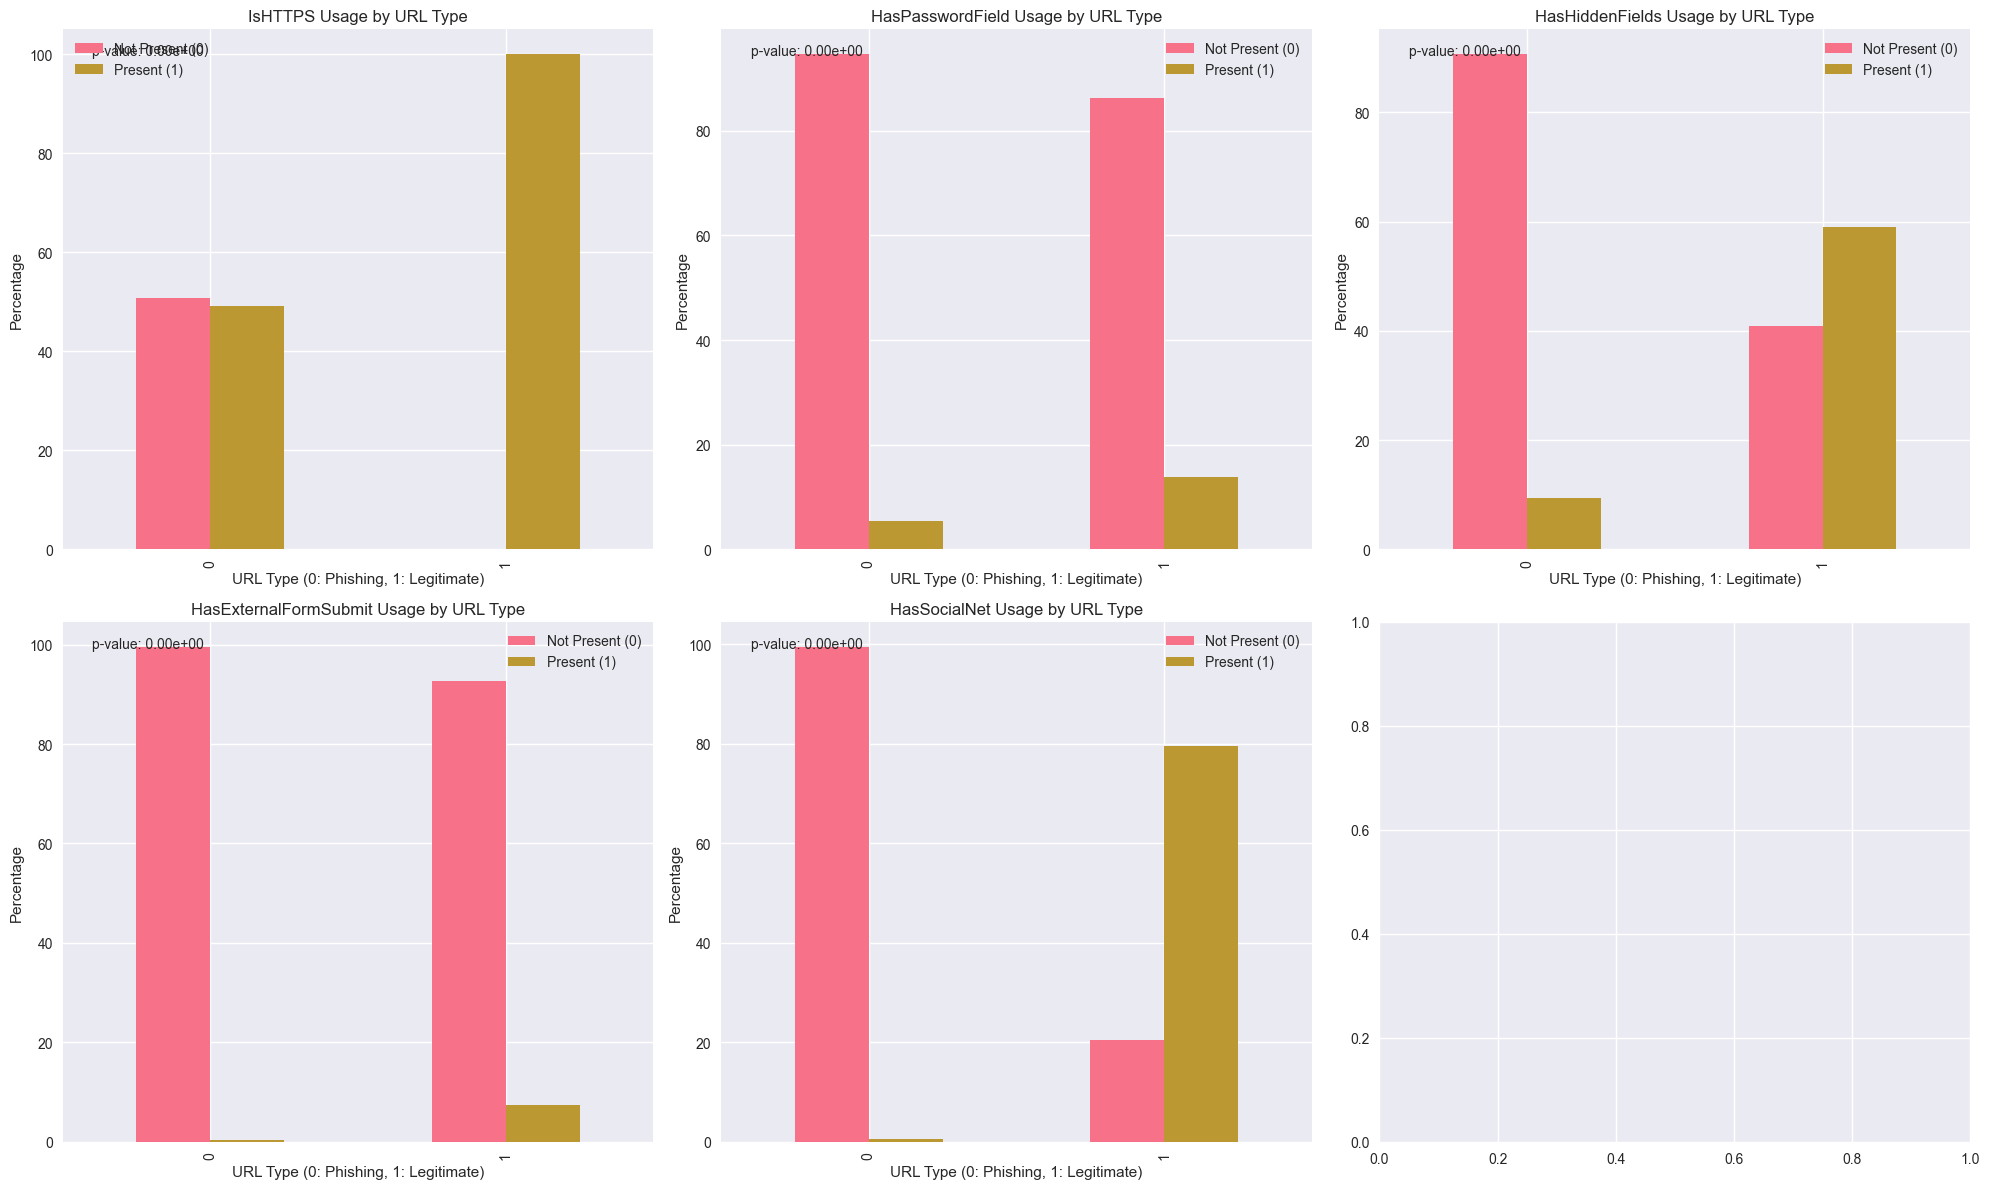

In [20]:

 def analyze_security_indicators(df):
 
    security_features = ['IsHTTPS', 'HasPasswordField','HasHiddenFields',
                         'HasExternalFormSubmit', 'HasSocialNet']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    for idx, feature in enumerate(security_features):
        if idx < len(axes):
            # Calculate percentages for each category
            feature_dist = df.groupby('label')[feature].value_counts(normalize=True).unstack() * 100
            # Create bar plot
            feature_dist.plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'{feature} Usage by URL Type')
            axes[idx].set_xlabel('URL Type (0: Phishing, 1: Legitimate)')
            axes[idx].set_ylabel('Percentage')
            axes[idx].legend(['Not Present (0)', 'Present (1)'])
            # Add chi-square test
            contingency = pd.crosstab(df['label'], df[feature])
            chi2, p_value = stats.chi2_contingency(contingency)[:2]
            axes[idx].text(0.05, 0.95, f'p-value: {p_value:.2e}', 
                           transform=axes[idx].transAxes)
    plt.tight_layout()
    plt.show()
 # Execute the analysis
 analyze_security_indicators(df)
 
 

## 5. Feature Importance Analysis
Analyze feature importance using SelectKBest

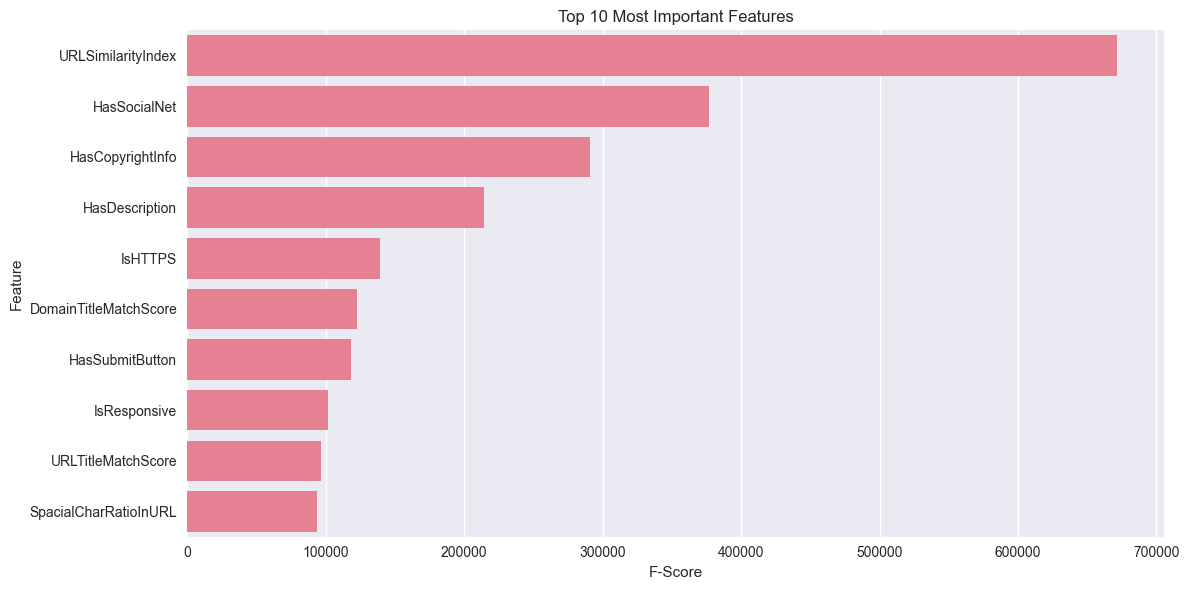

In [21]:

 def feature_importance_analysis(df):
 
    # Prepare features
    X = df.select_dtypes(include=[np.number]).drop('label', axis=1)
    y = df['label']
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Select top features
    selector = SelectKBest(score_func=f_classif, k=10)
    selector.fit(X_scaled, y)
    # Get feature scores
    feature_scores = pd.DataFrame({'Feature': X.columns,
                                   'Score': selector.scores_
                                   }).sort_values('Score', ascending=False)
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Score', y='Feature', data=feature_scores.head(10))
    plt.title('Top 10 Most Important Features')
    plt.xlabel('F-Score')
    plt.tight_layout()
    plt.show()
    return feature_scores


 # Execute the analysis
 feature_scores = feature_importance_analysis(df)
 


Top 10 Most Important Features:
                  Feature          Score
3      URLSimilarityIndex  671857.021357
36           HasSocialNet  376744.060223
43       HasCopyrightInfo  291213.405607
32         HasDescription  214554.534151
21                IsHTTPS  139101.470625
25  DomainTitleMatchScore  122616.776205
37        HasSubmitButton  118640.503918
29           IsResponsive  101521.680953
26     URLTitleMatchScore   96765.322906
20  SpacialCharRatioInURL   93831.344742


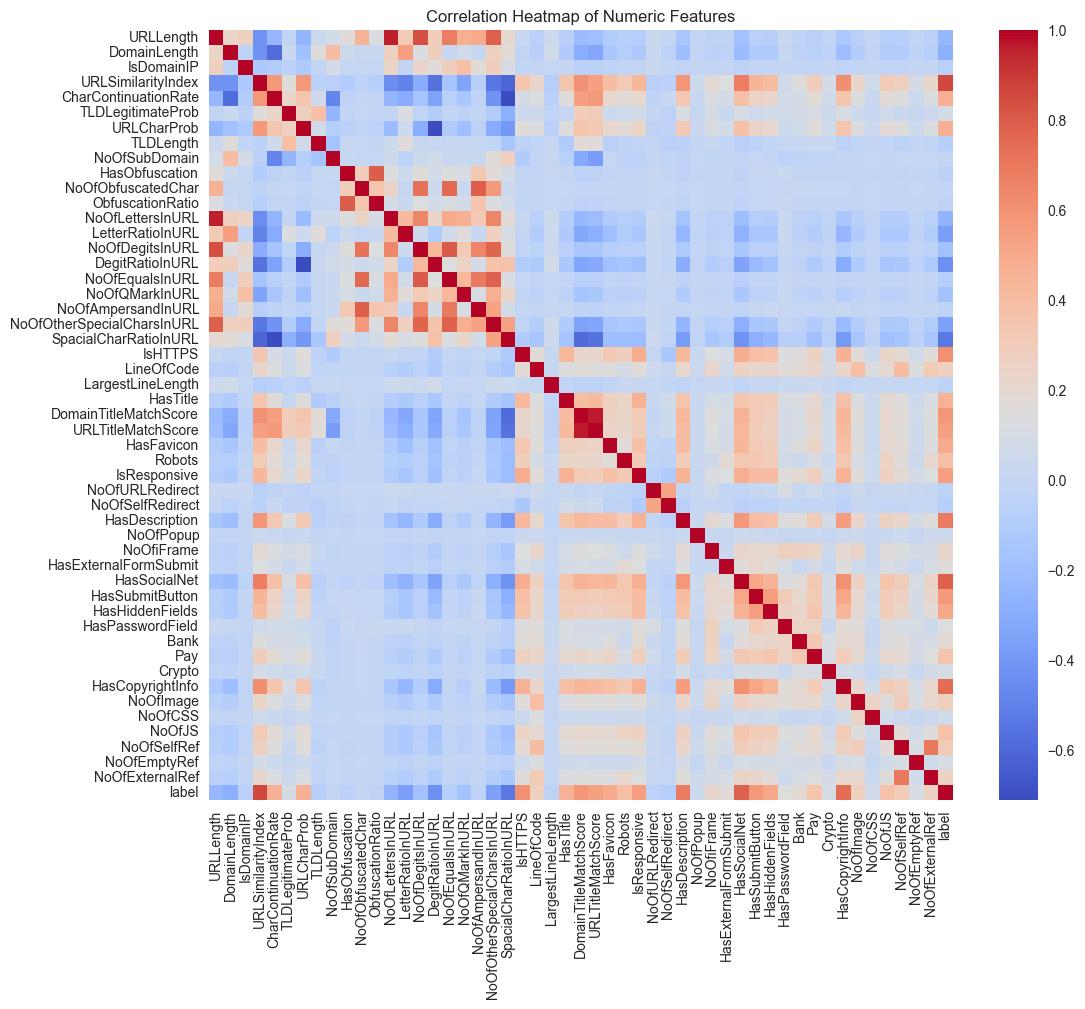

In [24]:
print("\nTop 10 Most Important Features:")
print(feature_scores.head(10)) 
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()
# Separate features and target
# Remove non-numeric and irrelevant columns
X = df.select_dtypes(include=[np.number]).drop('label', axis=1)
y = df['label']

## 6. Feature Importance Across Multiple Algorithms
Compare feature importance across different algorithms

C:\Users\Earl\AppData\Local\Temp\ipykernel_6232\3200273748.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp_df.head(10), palette='viridis')
C:\Users\Earl\AppData\Local\Temp\ipykernel_6232\3200273748.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp_df.head(10), palette='viridis')
C:\Users\Earl\AppData\Local\Temp\ipykernel_6232\3200273748.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp_df.head(1

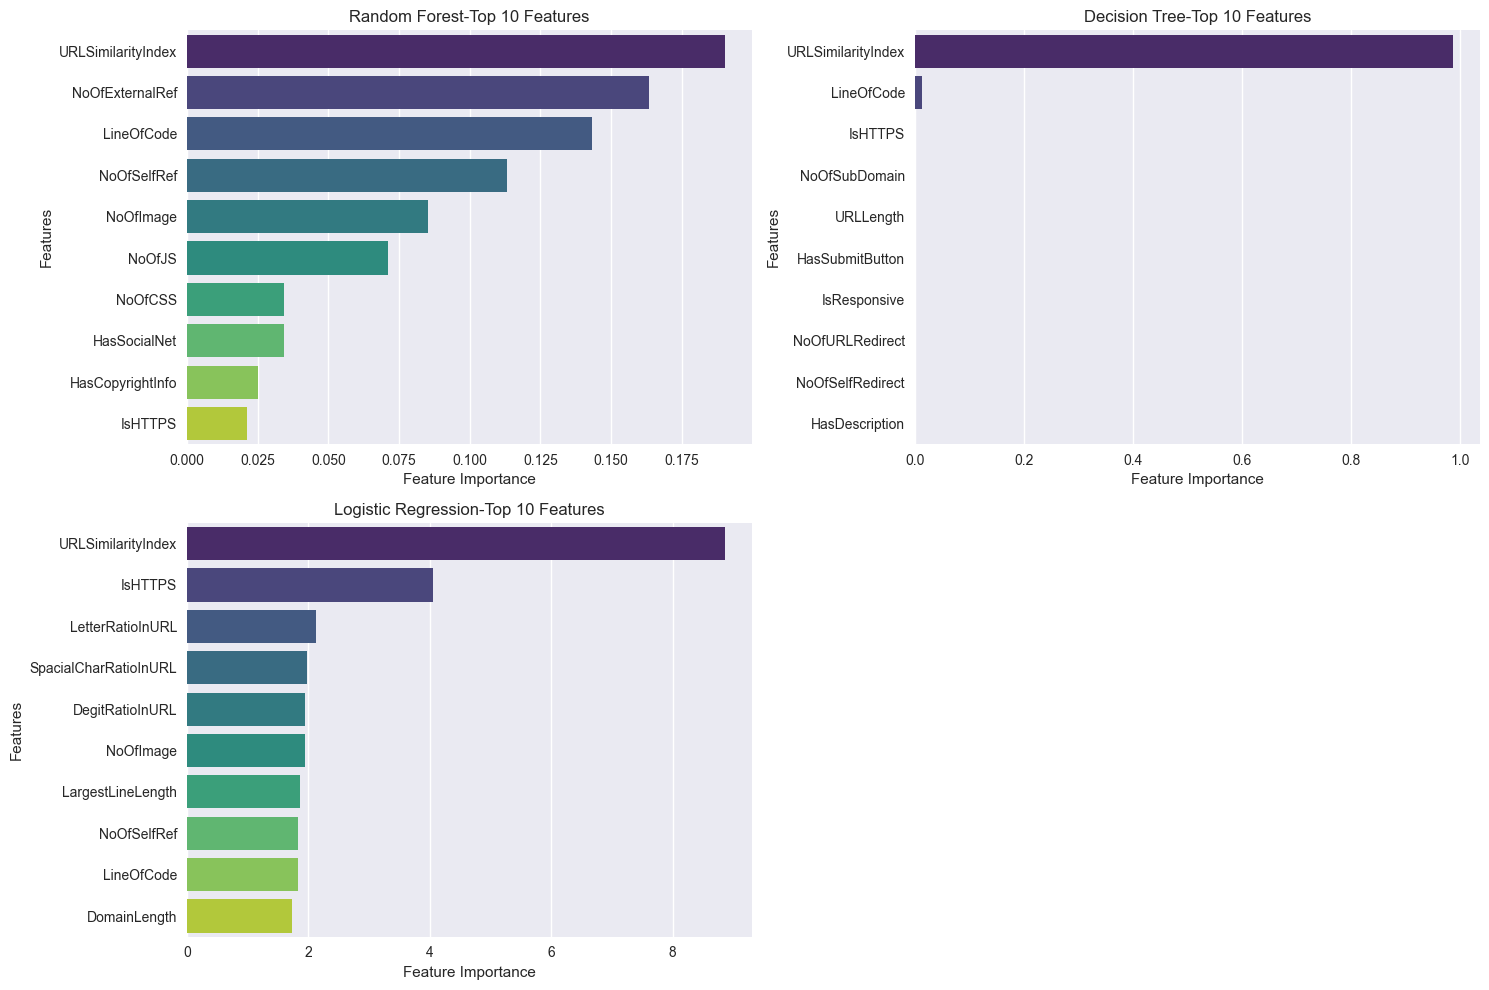

In [25]:

 def compare_feature_importance(X, y):

    # Initialize classifiers

    classifiers = {'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
                   'Decision Tree': DecisionTreeClassifier(random_state=42),
                   'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)}
    # Store feature importances
    feature_importances = {}
    # Prepare a figure for visualization
    plt.figure(figsize=(15, 10))
    # Iterate through classifiers
    for idx, (name, clf) in enumerate(classifiers.items(), 1):
        # Prepare pipeline with scaling
        pipeline = Pipeline([('scaler', StandardScaler()),('classifier', clf)])
        # Fit the pipeline
        pipeline.fit(X, y)
        # Extract classifier
        actual_clf = pipeline.named_steps['classifier']
        # Get feature importances based on algorithm type
        if name == 'Random Forest':
            importances = actual_clf.feature_importances_
        elif name == 'Decision Tree':
            importances = actual_clf.feature_importances_
        elif name == 'Logistic Regression':
            importances = np.abs(actual_clf.coef_[0])
        # Create a DataFrame of feature importances
        feature_imp_df = pd.DataFrame({'feature': X.columns,
                                       'importance': importances
                                       }).sort_values('importance', ascending=False)
        # Store in dictionary
        feature_importances[name] = feature_imp_df
        # Subplot for each classifier
        plt.subplot(2, 2, idx)
        sns.barplot(x='importance', y='feature', data=feature_imp_df.head(10), palette='viridis')
        plt.title(f'{name}-Top 10 Features')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    return feature_importances
 # Run feature importance comparison
 feature_importances = compare_feature_importance(X, y)


## 7. Model Performance Comparison
Compare performance of different classifiers


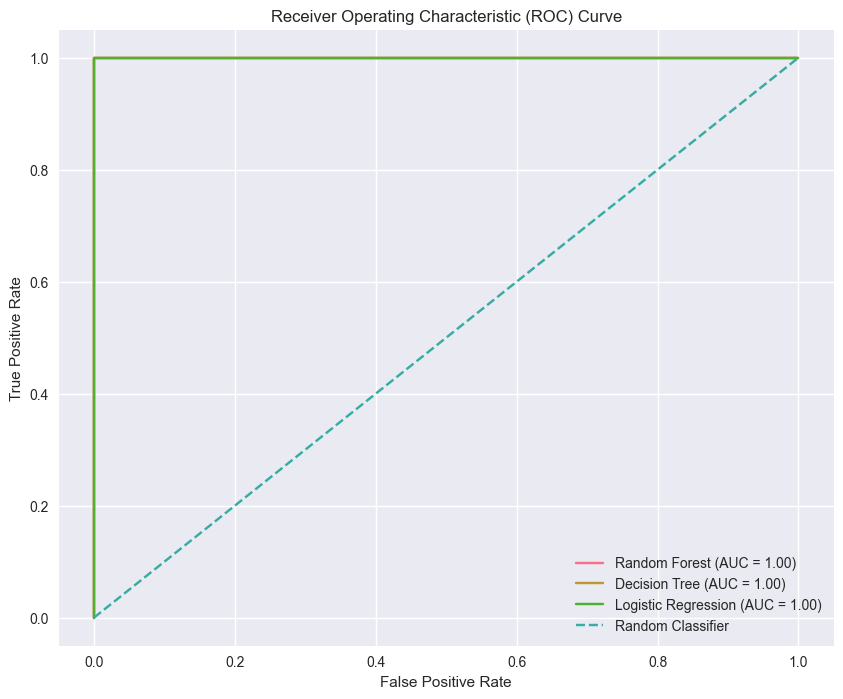

Model Performance Metrics:

Random Forest Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cross-Validation Mean: 1.0000
Cross-Validation Std: 0.0000

Decision Tree Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cross-Validation Mean: 1.0000
Cross-Validation Std: 0.0000

Logistic Regression Performance:
Accuracy: 0.9999
Precision: 0.9999
Recall: 1.0000
F1 Score: 0.9999
ROC AUC: 1.0000
Cross-Validation Mean: 0.9999
Cross-Validation Std: 0.0000


In [26]:

 def compare_model_performance(X, y):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Initialize classifiers
    classifiers = {'Random Forest': RandomForestClassifier(n_estimators=100,random_state=42),
                   'Decision Tree': DecisionTreeClassifier(random_state=42),
                   'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)}
    # Performance metrics storage
    performance_metrics = {}
    # Prepare a figure for ROC curves
    plt.figure(figsize=(10, 8))
    # Iterate through classifiers
    for name, clf in classifiers.items():
        # Prepare pipeline with scaling
        pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', clf)])
        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X, y, cv=5)
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        # Predict
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        # Calculate performance metrics
        metrics = {'Accuracy': accuracy_score(y_test, y_pred),
                   'Precision': precision_score(y_test, y_pred),
                   'Recall': recall_score(y_test, y_pred),
                   'F1 Score': f1_score(y_test, y_pred),
                   'ROC AUC': roc_auc_score(y_test, y_pred_proba),
                   'Cross-Validation Mean': cv_scores.mean(),
                   'Cross-Validation Std': cv_scores.std()
        }
        performance_metrics[name] = metrics
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["ROC AUC"]:.2f})')
    # ROC curve details
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    # Print performance metrics
    print("Model Performance Metrics:")
    for name, metrics in performance_metrics.items():
        print(f"\n{name} Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    return performance_metrics
 # Run model performance comparison
 performance_metrics = compare_model_performance(X, y)

## 8. Detailed Classification Report
 Generate detailed classification report for Random Forest
 


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



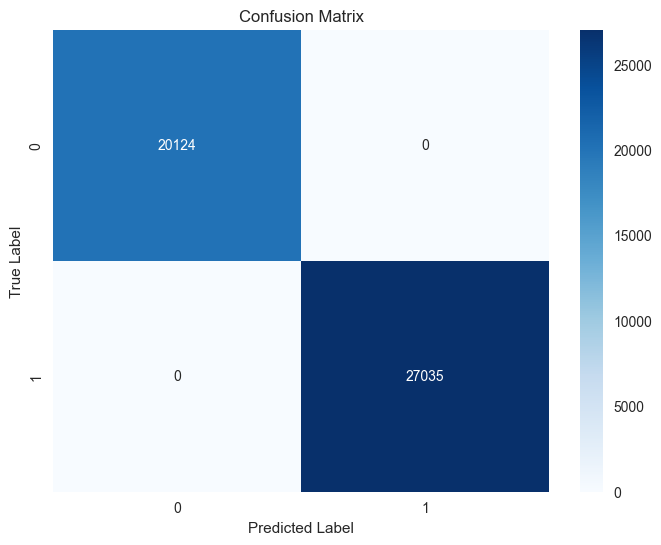

In [27]:

 def generate_detailed_classification_report(X, y):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Prepare pipeline
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    # Predict
    y_pred = pipeline.predict(X_test)
    # Generate and print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
 # Generate detailed classification report
 generate_detailed_classification_report(X, y)

## 9. Summary Statistics by URL Type

In [28]:
 
 # Calculate summary statistics for key numerical features by URL type
 key_features = ['URLLength', 'DomainLength', 'NoOfSubDomain',
                 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfOtherSpecialCharsInURL']
 print("Summary Statistics for Legitimate URLs (label=1):")
 print(df[df['label'] == 1][key_features].describe())
 print("\nSummary Statistics for Phishing URLs (label=0):")
 print(df[df['label'] == 0][key_features].describe())

Summary Statistics for Legitimate URLs (label=1):
           URLLength   DomainLength  NoOfSubDomain  NoOfLettersInURL  \
count  134850.000000  134850.000000  134850.000000     134850.000000   
mean       26.228610      19.228610       1.161661         12.933059   
std         4.815612       4.815612       0.404076          4.782969   
min        15.000000       8.000000       1.000000          1.000000   
25%        23.000000      16.000000       1.000000          9.000000   
50%        26.000000      19.000000       1.000000         13.000000   
75%        29.000000      22.000000       1.000000         16.000000   
max        57.000000      50.000000       4.000000         44.000000   

       NoOfDegitsInURL  NoOfOtherSpecialCharsInURL  
count    134850.000000               134850.000000  
mean          0.050597                    1.244835  
std           0.350326                    0.503961  
min           0.000000                    0.000000  
25%           0.000000              

## 10. HTTPS usage in phishing vs legitimate URLs

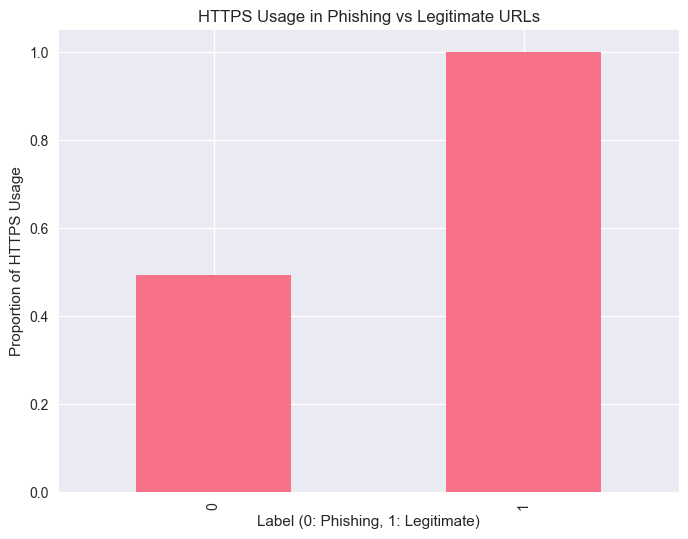

In [29]:

 https_usage = df.groupby('label')['IsHTTPS'].mean()
 plt.figure(figsize=(8, 6))
 https_usage.plot(kind='bar')
 plt.title('HTTPS Usage in Phishing vs Legitimate URLs')
 plt.xlabel('Label (0: Phishing, 1: Legitimate)')
 plt.ylabel('Proportion of HTTPS Usage')
 plt.show()

## 11. Potential relationships between variables

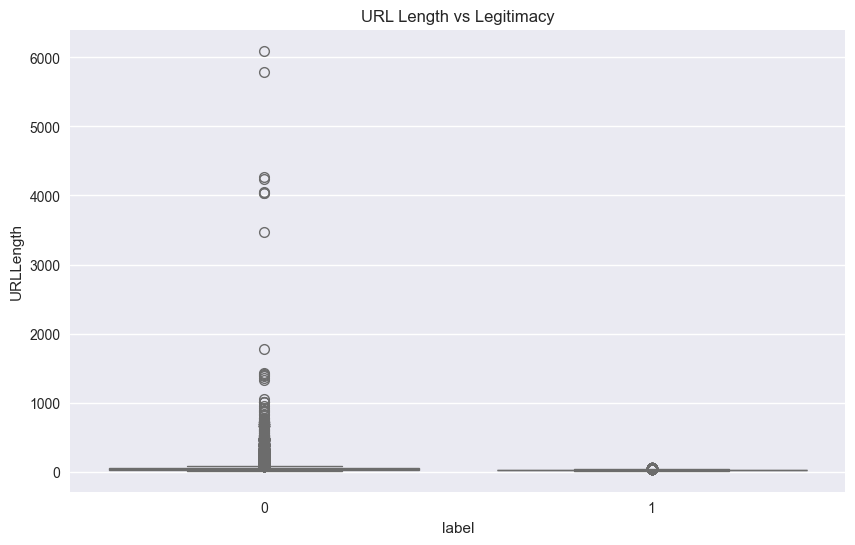

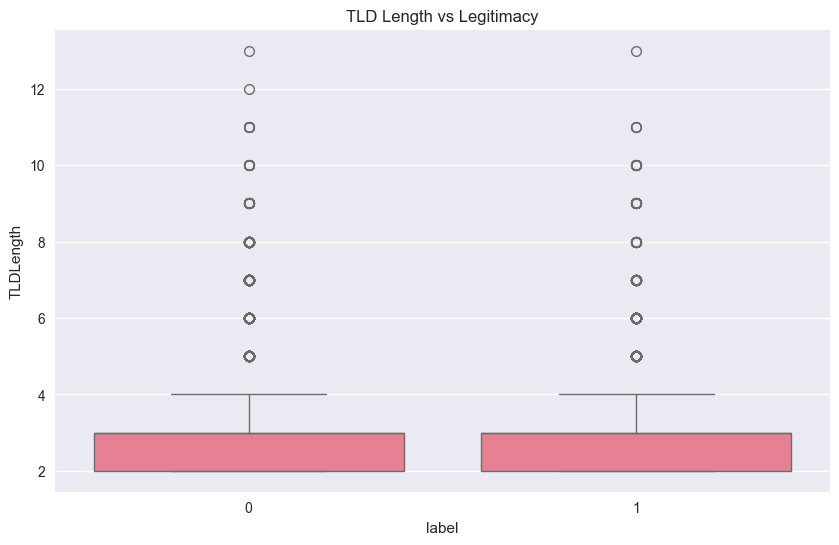


Top 10 most common TLDs:
TLD
com    112554
org     18793
net      7097
app      6508
uk       6395
co       5422
io       4201
de       3996
ru       3875
au       2979
Name: count, dtype: int64

Mean values of key features for phishing and legitimate URLs:
       URLLength  DomainLength  NoOfSubDomain  TLDLength  NoOfURLRedirect  \
label                                                                       
0      45.720293     24.465144       1.168894   2.819327         0.151696   
1      26.228610     19.228610       1.161661   2.723382         0.119770   

       HasHiddenFields  
label                   
0             0.093279  
1             0.590782  


In [30]:

 # Relationship between URL length and legitimacy
 plt.figure(figsize=(10, 6))
 sns.boxplot(x='label', y='URLLength', data=df)
 plt.title('URL Length vs Legitimacy')
 plt.show()
 # Relationship between TLD length and legitimacy
 plt.figure(figsize=(10, 6))
 sns.boxplot(x='label', y='TLDLength', data=df)
 plt.title('TLD Length vs Legitimacy')
 plt.show()
 print("\nTop 10 most common TLDs:")
 print(df['TLD'].value_counts().head(10))
 print("\nMean values of key features for phishing and legitimate URLs:")
 key_features = ['URLLength', 'DomainLength', 'NoOfSubDomain', 'TLDLength', 'NoOfURLRedirect', 'HasHiddenFields']
 print(df.groupby('label')[key_features].mean())
 # Separate features and target
 X = df.drop(['label', 'FILENAME', 'URL', 'Domain', 'TLD', 'Title'], axis=1)
 y = df['label']


Question 1: Which features are the most significant indicators of a phishing URL?


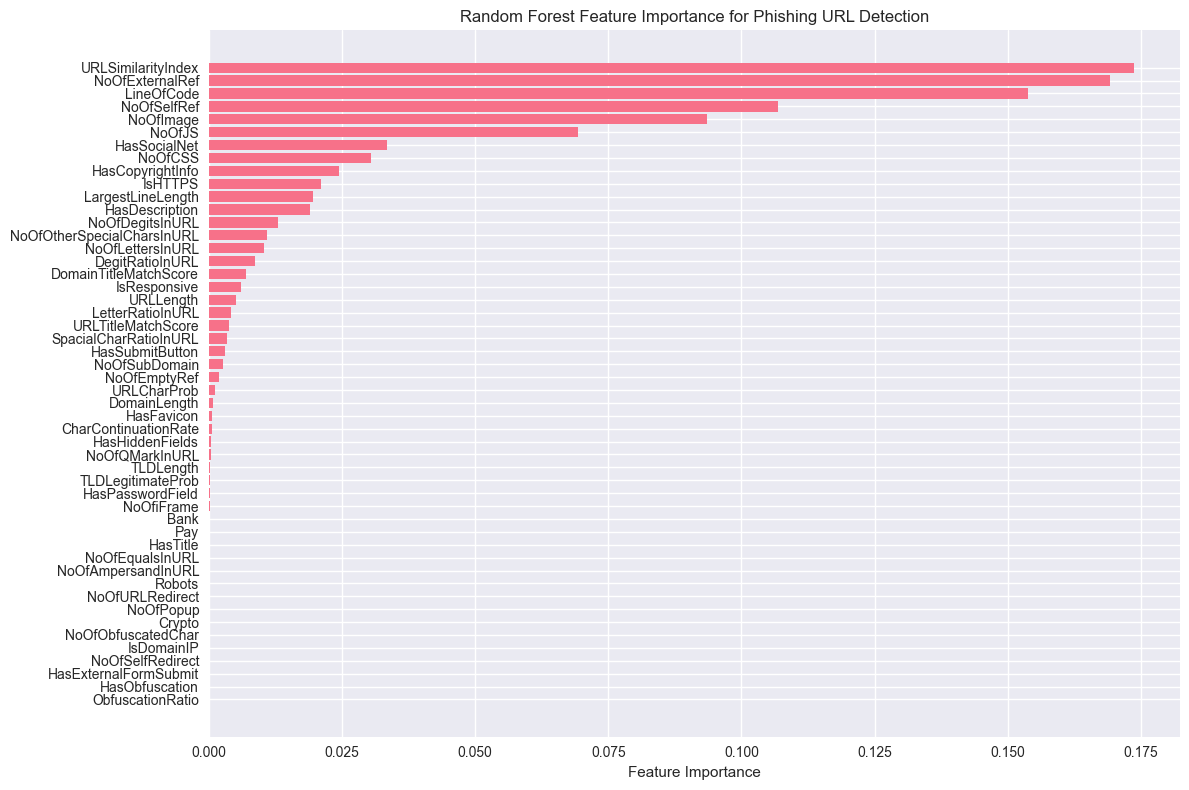


Top 10 most important features:
1. URLSimilarityIndex: 0.1737
2. NoOfExternalRef: 0.1693
3. LineOfCode: 0.1538
4. NoOfSelfRef: 0.1068
5. NoOfImage: 0.0935
6. NoOfJS: 0.0693
7. HasSocialNet: 0.0334
8. NoOfCSS: 0.0305
9. HasCopyrightInfo: 0.0245
10. IsHTTPS: 0.0211

Performance using ['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS'] features:
Accuracy: 0.9999

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00     

In [34]:
 # Split the data
 X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size=0.2, random_state=42)
 # Standardize the features
 scaler = StandardScaler()
 X_train_scaled = scaler.fit_transform(X_train)
 X_test_scaled = scaler.transform(X_test)
 print("Question 1: Which features are the most significant indicators of a phishing URL?")
# Train a Random Forest classifier
 rf_classifier = RandomForestClassifier(n_estimators=100,
 random_state=42)
 rf_classifier.fit(X_train_scaled, y_train)
 # Get feature importances
 feature_importance = rf_classifier.feature_importances_
 feature_names = X.columns
 # Sort features by importance
 sorted_idx = np.argsort(feature_importance)
 sorted_features = feature_names[sorted_idx]
 sorted_importance = feature_importance[sorted_idx]
 # Plot feature importances
 plt.figure(figsize=(12, 8))
 plt.barh(range(len(sorted_importance)), sorted_importance)
 plt.yticks(range(len(sorted_importance)), sorted_features)
 plt.xlabel('Feature Importance')
 plt.title('Random Forest Feature Importance for Phishing URL Detection')
 plt.tight_layout()
 plt.show()
 print("\nTop 10 most important features:")
 for i in range(1, 11):
    print(f"{i}. {sorted_features[-i]}: {sorted_importance[-i]:.4f}")
 # Define URL-based and webpage content-based features
 url_features = ['URLLength', 'DomainLength', 'IsDomainIP',
 'URLSimilarityIndex', 'CharContinuationRate',
 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
 'NoOfSubDomain', 'HasObfuscation',
 'NoOfObfuscatedChar', 'ObfuscationRatio',
 'NoOfLettersInURL', 'LetterRatioInURL',
 'NoOfDegitsInURL', 'DegitRatioInURL',
 'NoOfEqualsInURL', 'NoOfQMarkInURL',
 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
 'SpacialCharRatioInURL', 'IsHTTPS']
 webpage_features = ['LineOfCode', 'LargestLineLength', 'HasTitle',
 'DomainTitleMatchScore',
 'URLTitleMatchScore', 'HasFavicon', 'Robots',
 'IsResponsive', 'NoOfURLRedirect',
 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup',
 'NoOfiFrame', 'HasExternalFormSubmit',
 'HasSocialNet', 'HasSubmitButton',
 'HasHiddenFields', 'HasPasswordField', 'Bank',
 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage',
 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
 'NoOfEmptyRef', 'NoOfExternalRef']
 # Function to train and evaluate a model
 def train_and_evaluate(X_train, X_test, y_train, y_test, feature_set_name):
    X_train_set = X_train[feature_set_name]
    X_test_set = X_test[feature_set_name]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_set)
    X_test_scaled = scaler.transform(X_test_set)
    rf_classifier = RandomForestClassifier(n_estimators=100,
    random_state=42)
    rf_classifier.fit(X_train_scaled, y_train)
    y_pred = rf_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nPerformance using {feature_set_name} features:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
 # Evaluate models using URL-based and webpage content-based features
 train_and_evaluate(X_train, X_test, y_train, y_test, url_features)
 train_and_evaluate(X_train, X_test, y_train, y_test, webpage_features)
 # Evaluate model using all features
 all_features = url_features + webpage_features 
 train_and_evaluate(X_train, X_test, y_train, y_test, all_features)